# Machine Learning Challenge

## Overview

The focus of this exercise is on a field within machine learning called [Natural Language Processing](https://en.wikipedia.org/wiki/Natural-language_processing). We can think of this field as the intersection between language, and machine learning. Tasks in this field include automatic translation (Google translate), intelligent personal assistants (Siri), information extraction, and speech recognition for example.

NLP uses many of the same techniques as traditional data science, but also features a number of specialised skills and approaches. There is no expectation that you have any experience with NLP, however, to complete the challenge it will be useful to have the following skills:

- understanding of the python programming language
- understanding of basic machine learning concepts, i.e. supervised learning


### Instructions

1. Download this notebook!
2. Answer each of the provided questions, including your source code as cells in this notebook.
3. Share the results with us, e.g. a Github repo.

### Task description

You will be performing a task known as [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis). Here, the goal is to predict sentiment -- the emotional intent behind a statement -- from text. For example, the sentence: "*This movie was terrible!"* has a negative sentiment, whereas "*loved this cinematic masterpiece*" has a positive sentiment.

To simplify the task, we consider sentiment binary: labels of `1` indicate a sentence has a positive sentiment, and labels of `0` indicate that the sentence has a negative sentiment.

### Dataset

The dataset is split across three files, representing three different sources -- Amazon, Yelp and IMDB. Your task is to build a sentiment analysis model using both the Yelp and IMDB data as your training-set, and test the performance of your model on the Amazon data.

Each file can be found in the `input` directory, and contains 1000 rows of data. Each row contains a sentence, a `tab` character and then a label -- `0` or `1`. 

**Notes**
- Feel free to use existing machine learning libraries as components in you solution!
- Suggested libraries: `sklearn` (for machine learning), `pandas` (for loading/processing data), `spacy` (for text processing).
- As mentioned, you are not expected to have previous experience with this exact task. You are free to refer to external tutorials/resources to assist you. However, you will be asked to justfify the choices you have made -- so make you understand the approach you have taken.

In [2]:
import os
print(os.listdir("./input"))

['amazon_cells_labelled.txt', 'imdb_labelled.txt', 'imdb_labelled2.txt', 'yelp_labelled.txt']


In [4]:
import nltk
import spacy
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import numpy as np

from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS

import gensim
from gensim.models import Word2Vec

import pandas as pd
import re

import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer


import gensim.downloader as api
import math
import transformers
from collections import Counter

In [5]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

## 1. Read and concatenate data into test and train sets

In [6]:
data1 = pd.read_csv('input/imdb_labelled2.txt',sep='\t',header=None)
data2 = pd.read_csv('input/yelp_labelled.txt',sep='\t',header=None)
data3 = pd.read_csv('input/amazon_cells_labelled.txt',sep='\t',header=None)

In [7]:
print(len(data1[0]))
print(len(data1[1]))
print(len(data2[0]))
print(len(data2[1]))
print(len(data3[0]))
print(len(data3[1]))

1000
1000
1000
1000
1000
1000


In [8]:
print(Counter(data1[1]))
print(Counter(data2[1]))
print(Counter(data3[1]))

Counter({0: 500, 1: 500})
Counter({1: 500, 0: 500})
Counter({0: 500, 1: 500})


In [9]:
def create_data(data):
    corps=[]
    label=[]
    for x,y in zip(data[0],data[1]):
        corps.append(x)
        label.append(y)
    return corps,label

In [10]:
D1,L1 = create_data(data1)
D2,L2 = create_data(data2)
D3,L3 = create_data(data3)

In [11]:
train_D = D1+D2
train_L = L1+L2
print(len(train_D))
print(len(train_L))

2000
2000


## 2. Prepare the data for input into your model

In [12]:
from nltk.corpus import stopwords as sw
stop_words = sw.words()

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

In [13]:
def remove_pun_stopword(data):
    sent = []
    for x in tknzr.tokenize(data):
        if x.lower() not in stop_words+puncts:
            sent.append(x)
    sents = (' ').join(sent)
    return sents

In [14]:
train_D2=[]
for x in train_D:
    train_D2.append(remove_pun_stopword(x))

In [15]:
train_T=[]
for x in D3:
    train_T.append(remove_pun_stopword(x))

In [16]:
len(train_T)

1000

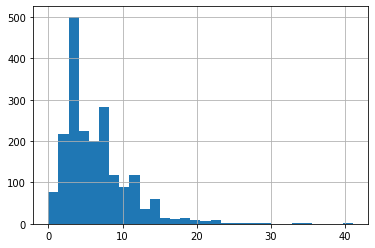

In [17]:
%matplotlib inline
seq_len = [len(x.split()) for x in train_D2]
pd.Series(seq_len).hist(bins=30)

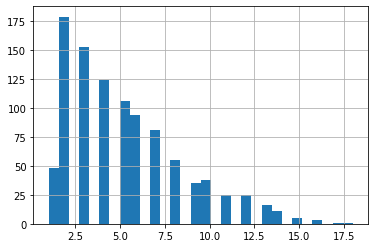

In [18]:
%matplotlib inline
seq_len = [len(x.split()) for x in train_T]
pd.Series(seq_len).hist(bins=30)

In [19]:

def clean_str(string):


    string = re.sub(r'\$\w*', '', string)
    # remove old style retweet text "RT"
    string = re.sub(r'^RT[\s]+', '', string)
    # remove hyperlinks
    string = re.sub(r'https?:\/\/.*[\r\n]*', '', string)

    # remove hashtags
    # only removing the hash # sign from the word
    string = re.sub(r'#', '', string)

    #string = remove_punctuation(string)
    #remove punch

    string = re.sub("\d+", "", string) #remove numbers

    string = re.sub("@[A-Za-z0-9]+","",string) #remove @ and its following contents
    string = re.sub("@[_A-Za-z0-9]+","",string)


    return string.strip().lower()
    

In [20]:
tknzr = TweetTokenizer()
library=[]
for x in train_D2:
    for y in tknzr.tokenize(x):
        library.append(y)

In [21]:
Counter(library)

Counter({'slow-moving': 1,
         'aimless': 1,
         'movie': 175,
         'distressed': 1,
         'drifting': 1,
         'young': 3,
         'sure': 11,
         'lost': 6,
         'flat': 4,
         'characters': 33,
         'audience': 5,
         'nearly': 2,
         'half': 9,
         'walked': 5,
         'Attempting': 1,
         'artiness': 1,
         'black': 8,
         'white': 11,
         'clever': 4,
         'camera': 8,
         'angles': 2,
         'disappointed': 24,
         'became': 2,
         'even': 51,
         'ridiculous': 6,
         'acting': 41,
         'poor': 11,
         'plot': 26,
         'lines': 7,
         'almost': 9,
         'non-existent': 1,
         'little': 27,
         'music': 17,
         'anything': 10,
         'speak': 3,
         'best': 41,
         'scene': 15,
         'Gerardo': 1,
         'trying': 6,
         'find': 13,
         'song': 4,
         'keeps': 2,
         'running': 6,
         'head': 3,
   

### 2a: Find the ten most frequent words in the training set.

In [22]:
total=Counter(library)
max(total, key=total. get)

'movie'

In [24]:
#######Preprocessing for Bert###################

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

max_len=20 

def preprocess_bert(data):
    input_index=[]
    input_att_mask=[]
    
    for x in data:
        encoded_sent = tokenizer.encode_plus(
        text=clean_str(x),
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        #pad_to_max_length=True,
        padding = 'max_length',
        return_attention_mask=True)
        
        input_index.append(encoded_sent.get('input_ids'))
        input_att_mask.append(encoded_sent.get('attention_mask'))
    
    return input_index, input_att_mask
    

In [25]:
data_index,data_masking = preprocess_bert(train_D2)

data_index_Test,data_masking_Test = preprocess_bert(train_T)

In [26]:
print(len(data_index))
print(len(train_D))
print(len(data_masking))
print(len(data_index_Test))
print(len(train_L))

2000
2000
2000
1000
2000


In [83]:
total_data = TensorDataset(torch.tensor(data_index).long(),torch.tensor(data_masking).long(),torch.tensor(train_L).long())
training_size=1700
validation_size=300

train,valid = torch.utils.data.random_split(total_data,[training_size,validation_size])
batch_size=20
train_data = DataLoader(train,batch_size=batch_size,shuffle=True)
valid_data = DataLoader(valid,batch_size=validation_size,shuffle=False)

In [84]:
test_dat = TensorDataset(torch.tensor(data_index_Test).long(),torch.tensor(data_masking_Test).long(),torch.tensor(L3).long())
test_data = DataLoader(test_dat,batch_size=1000,shuffle=False)
testing_size=len(test_dat)

## 3. Train your model and justify your choices.

In [85]:
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self,embedding_dim,hidden_dim,output_dim,freeze_bert=False):  
        #Please note if freeze_bert = True means we not fine tuning the Bert model
        super(BertClassifier,self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.lr1 = nn.Linear(embedding_dim,hidden_dim*2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0/5)
        self.lr1_2 = nn.Linear(hidden_dim*2,hidden_dim)
        self.lr2 = nn.Linear(hidden_dim,output_dim)
        
        if freeze_bert==True:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self,data, data_mask):
        data = self.bert(input_ids = data, attention_mask = data_mask)
        output = data[0][:,0,:]
    # there r two items in Bert output, first is last hidden state [batch, len, embed] and second is pooler_ouput [batch, embed]
        output = self.lr1(output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.lr1_2(output)
        output = self.lr2(output)
        #output = torch.sigmoid(output)
        
        
        return output

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mymodel= BertClassifier(768,100,2,freeze_bert=True).to(device)

In [87]:
import torch.optim as optim
from transformers import AdamW
from sklearn.metrics import classification_report,f1_score

opti = optim.Adam(mymodel.parameters(), lr=0.001)
#opti = AdamW(mymodel.parameters(),lr=0.0005, eps=1e-8)
opti_scheduler=torch.optim.lr_scheduler.StepLR(opti,step_size=400,gamma=0.95)
loss_fun = nn.CrossEntropyLoss()
#loss_fun = nn.BCELoss()
#loss_fun=nn.BCEWithLogitsLoss()


epoch = 20
Train_acc = []
Train_f1 = []
Valid_acc = []
Valid_f1 = []
for c in range(epoch):
    mymodel.train()
    acc=0
    f1=0
    for n,(x,y,z) in enumerate(train_data):
        opti.zero_grad()
        x,y,z = x.to(device),y.to(device),z.to(device)
        output = mymodel(x,y)
        loss = loss_fun(output,z)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(mymodel.parameters(), 1.0)
        opti.step()
        opti_scheduler.step()
        prediction = torch.argmax(output,-1)
        #######
#         train_pred.append(prediction.cpu().numpy())
#         train_lab.append(z.cpu())
        batch_f1 = f1_score(z.cpu(),prediction.cpu().numpy(),average='weighted')
        f1+=batch_f1
        #prediction = torch.round(output)
        ######
        accu = torch.sum(prediction==z).item()
        #accu = torch.sum(prediction.squeeze(1)==z).item()
        acc+=accu
        
        if (n+1)%20==0:
            print('Batch [{}] with loss of [{:.7f}] and accuracy of [{:.2%}]'.format(n+1,loss,accu/batch_size))
    Train_f1.append(f1/85)
    Train_acc.append(acc/training_size)
    print('Training accuracy of epoch [{}] is [{:.2%}]'.format(c+1,acc/training_size))
    
    if (c+1)%1==0:
        with torch.no_grad():
            mymodel.eval()
            acc2=0
            for m,(xx,yy,zz) in enumerate(valid_data):
                xx,yy,zz = xx.to(device),yy.to(device),zz.to(device)
                output = mymodel(xx,yy)
                pred = torch.argmax(output,-1)
                acc2+=torch.sum(pred==zz).item()
            Valid_f1.append(f1_score(zz.cpu(),pred.cpu().numpy(),average='weighted'))
            Valid_acc.append(acc2/validation_size)
            print('Valid accuracy for epoch [{}] is [{:.2%}]'.format(c+1,acc2/validation_size))
            

Batch [20] with loss of [0.5574295] and accuracy of [75.00%]
Batch [40] with loss of [0.6513421] and accuracy of [60.00%]
Batch [60] with loss of [0.6426017] and accuracy of [70.00%]
Batch [80] with loss of [0.4782255] and accuracy of [80.00%]
Training accuracy of epoch [1] is [69.94%]
Valid accuracy for epoch [1] is [77.67%]
Batch [20] with loss of [0.5714929] and accuracy of [75.00%]
Batch [40] with loss of [0.4752657] and accuracy of [75.00%]
Batch [60] with loss of [0.4045363] and accuracy of [75.00%]
Batch [80] with loss of [0.6103560] and accuracy of [80.00%]
Training accuracy of epoch [2] is [78.65%]
Valid accuracy for epoch [2] is [79.33%]
Batch [20] with loss of [0.4814612] and accuracy of [80.00%]
Batch [40] with loss of [0.4725952] and accuracy of [85.00%]
Batch [60] with loss of [0.6467878] and accuracy of [80.00%]
Batch [80] with loss of [0.5088383] and accuracy of [70.00%]
Training accuracy of epoch [3] is [77.35%]
Valid accuracy for epoch [3] is [78.33%]
Batch [20] with 

Text(0, 0.5, 'F1 score')

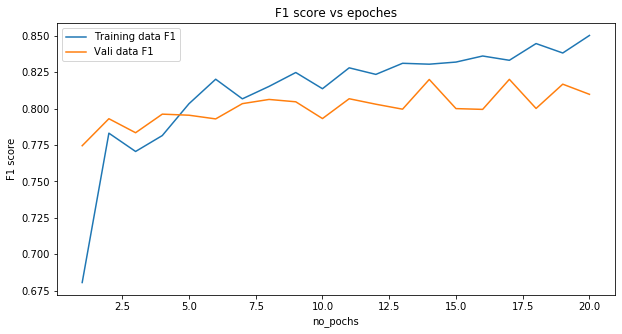

In [99]:
from matplotlib import pyplot as plt
epoch=[x for x in range(1,21)]
plt.figure(figsize=(10,5)) 
plt.plot(epoch,Train_f1,label='Training data F1')
plt.plot(epoch,Valid_f1,label='Vali data F1')
plt.legend()
plt.title('F1 score vs epoches')
plt.xlabel('no_pochs')
plt.ylabel('F1 score')

Text(0, 0.5, 'Accuracy')

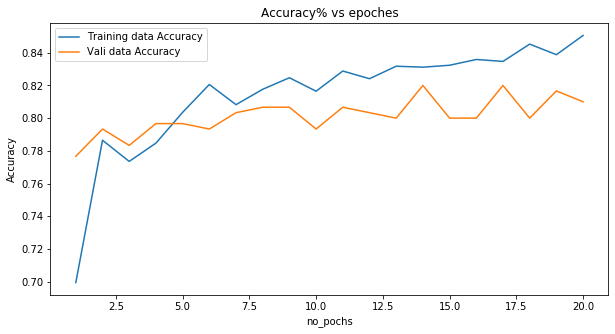

In [101]:

epoch=[x for x in range(1,21)]
plt.figure(figsize=(10,5)) 
plt.plot(epoch,Train_acc,label='Training data Accuracy')
plt.plot(epoch,Valid_acc,label='Vali data Accuracy')
plt.legend()
plt.title('Accuracy% vs epoches')
plt.xlabel('no_pochs')
plt.ylabel('Accuracy')

## 4. Evaluate your model using metric(s) you see fit and justify your choices

In [114]:

with torch.no_grad():
    mymodel.eval()
    acc2=0
    for m,(xx,yy,zz) in enumerate(test_data):
        xx,yy,zz = xx.to(device),yy.to(device),zz.to(device)
        output = mymodel(xx,yy)
        pred = torch.argmax(output,-1)
        #pred = torch.round(output)
        acc2+=torch.sum(pred==zz).item()
        f1=f1_score(zz.cpu(),pred.cpu().numpy(),average='weighted')
        #acc2+=torch.sum(pred.squeeze(1)==zz).item()
    print('Test accuracy for epoch [{}] is [{:.4%}]'.format(c+1,acc2/testing_size))
    print('F1 score: {:.5f} for test data'.format(f1))

Test accuracy for epoch [20] is [80.1000%]
F1 score: 0.80098 for test data
